# Import/Definitions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scintools.ththmod as THTH
from matplotlib.colors import LogNorm
import astropy.units as u
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit

In [2]:
##Function for making extent tuple for plotting
def ext_find(x,y):
    dx=np.diff(x).mean()
    dy=np.diff(y).mean()
    ext=[(x[0]-dx/2).value,(x[-1]+dx/2).value,(y[0]-dy/2).value,(y[-1]+dy/2).value]
    return(ext)

##Curvature evolution with freuquency
def eta_func(f0,A):
    return(A/(f0**2))

# Load and Visualize Data

Text(0.5, 1.0, 'Secondary Spectrum')

/mnt/scratch-lustre/dbaker/.local/lib/python3.6/site-packages/matplotlib/colors.py:1030: RuntimeWarning: overflow encountered in log
  np.log(resdat, resdat)
/mnt/scratch-lustre/dbaker/.local/lib/python3.6/site-packages/matplotlib/colors.py:1030: RuntimeWarning: invalid value encountered in log
  np.log(resdat, resdat)


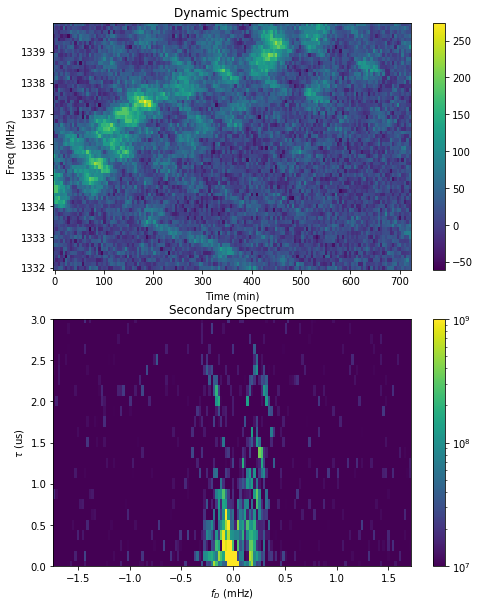

In [3]:
##Load Sample Data
arch=np.load('Sample_Data.npz')
time=arch['t_s']*u.s
freq=arch['f_MHz']*u.MHz
##Define Wavefield
espec=arch['Espec']
##Create noisy dynamic spectrum
dspec=np.abs(espec)**2+np.random.normal(0,20,espec.shape)

fd=np.fft.fftshift(np.fft.fftfreq(time.shape[0],time[1]-time[0]).to(u.mHz))*u.mHz
tau=np.fft.fftshift(np.fft.fftfreq(freq[:64].shape[0],
                                   freq[1]-freq[0]).to(u.us))*u.us

plt.figure(figsize=(8,10))
plt.subplot(211)
plt.imshow(dspec[:64],origin='lower',aspect='auto',extent=ext_find(time.to(u.min),freq[:64]))
SS=np.fft.fftshift(np.abs(np.fft.fft2(dspec[:64,:]))**2)
plt.xlabel('Time (min)')
plt.ylabel('Freq (MHz)')
plt.title('Dynamic Spectrum')
plt.colorbar()
plt.subplot(212)
plt.imshow(SS,norm=LogNorm(),origin='lower',aspect='auto',extent=ext_find(fd,tau),vmax=1e9,vmin=1e7)
plt.ylim((0,3))
plt.colorbar()
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Secondary Spectrum')


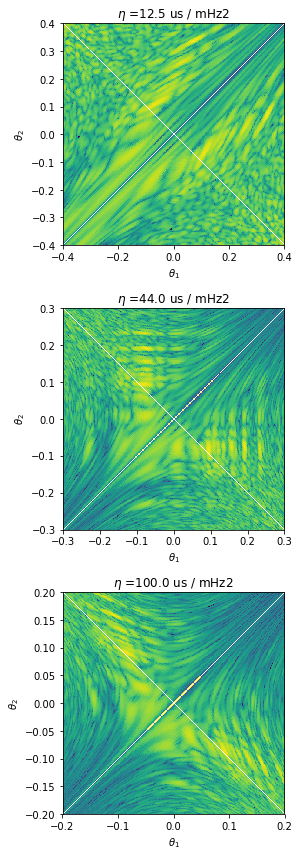

In [4]:
##Sample thth plots for a small portion of data
dspec2=dspec[:64]
freq2=freq[:64]

##Pad before forming secondary spectrum
npad=3
dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

##Form SS and coordinate arrays
SS=np.fft.fftshift(np.fft.fft2(dspec_pad))
fd=np.fft.fftshift(np.fft.fftfreq((npad+1)*time.shape[0],time[1]-time[0]).to(u.mHz))*u.mHz
tau=np.fft.fftshift(np.fft.fftfreq((npad+1)*freq2.shape[0],freq[1]-freq[0]).to(u.us))*u.us
plt.figure(figsize=(4,12))
etas=np.array([12.5,44,100])*u.us/u.mHz**2

##Bin Edges for thth plot 
##(should be symmetric about 0 and contain an even number of points)
edges=np.linspace(-.4,.4,512)

for i in range(3):
    ##Create thth plot
    ##The redmap fuction automatically crops the array to stay within the SS
    thth_red,edges_red=THTH.thth_redmap(SS, tau, fd, etas[i], edges)
    plt.subplot(3,1,i+1)
    plt.imshow(np.abs(thth_red),
               norm=LogNorm(),
               extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],
               origin='lower')
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title(r'$\eta$ =%s' %etas[i])
plt.tight_layout()

# Single Curvature Measurement

## Calculation

In [5]:
##Sample Curvature Search and Plots for Small Chunk of Data
dspec2=dspec[:64]
freq2=freq[:64]

##Pad before forming secondary spectrum
npad=3
dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

##Form SS and coordinate arrays
SS=np.fft.fftshift(np.fft.fft2(dspec_pad))
fd=np.fft.fftshift(np.fft.fftfreq((npad+1)*time.shape[0],time[1]-time[0]).to(u.mHz))*u.mHz
tau=np.fft.fftshift(np.fft.fftfreq((npad+1)*freq2.shape[0],freq[1]-freq[0]).to(u.us))*u.us

##Define range of curvatures to search
eta_low=.5*u.us/(.04*u.mHz**2)
eta_high=4*u.us/(.04*u.mHz**2)


##Estimate noise in dynamic spectrum
temp=np.fft.fftshift(np.abs(np.fft.fft2(dspec)/np.sqrt(dspec.shape[0]*dspec.shape[1]))**2)
N=np.sqrt(temp[:temp.shape[0]//6,:temp.shape[1]//6].mean())

##Setup for chisq search
etas=np.linspace(eta_low.value,eta_high.value,100)*eta_low.unit
chisq=np.zeros(etas.shape[0])

##Determine chisq for each curvature
for i in range(etas.shape[0]):
    eta=etas[i]
    ##Create thth plot
    ##The redmap fuction automatically crops the array to stay within the SS
    thth_red,edges_red=THTH.thth_redmap(SS, tau, fd, eta, edges)
    ##Find first eigenvector and value
    w,V=eigsh(thth_red,1)
    w=w[0]
    V=V[:,0]
    ##Use larges eigenvector/value as model
    thth2_red=np.outer(V,np.conjugate(V))
    thth2_red*=np.abs(w)
    ##Map back to SS for high
    recov=THTH.rev_map(thth2_red,tau,fd,eta,edges_red)
    model=2*np.fft.ifft2(np.fft.ifftshift(recov))[:dspec2.shape[0],:dspec2.shape[1]].real
    chisq[i]=(((dspec2-model)**2)/N).sum()

##Fit for a parabola around the minimum
e_min=etas[chisq==chisq.min()][0]
etas_fit=etas[np.abs(etas-e_min)<.1*e_min]
chisq_fit=chisq[np.abs(etas-e_min)<.1*e_min]
C=chisq_fit.min()
x0=etas_fit[chisq_fit==C][0].value
A=(chisq_fit[0]-C)/((etas_fit[0].value-x0)**2)
popt,pcov=curve_fit(THTH.chi_par,etas_fit.value,chisq_fit,p0=np.array([A,x0,C]))
eta_fit=popt[1]*etas.unit
eta_sig=np.sqrt((chisq_fit-THTH.chi_par(etas_fit.value,*popt)).std()/popt[0])*etas.unit


/opt/python/intelpython3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/python/intelpython3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/scratch-lustre/dbaker/.local/lib/python3.6/site-packages/scintools-0.1-py3.6.egg/scintools/ththmod.py:109: RuntimeWarning: invalid value encountered in true_divide
  bins=(fd_edges,tau_edges))[0]


## Plots

/opt/python/intelpython3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/python/intelpython3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/cita/h/home-2/dbaker/.local/lib/python3.6/site-packages/scintools-0.1-py3.6.egg/scintools/ththmod.py:109: RuntimeWarning: invalid value encountered in true_divide
  bins=(fd_edges,tau_edges))[0]


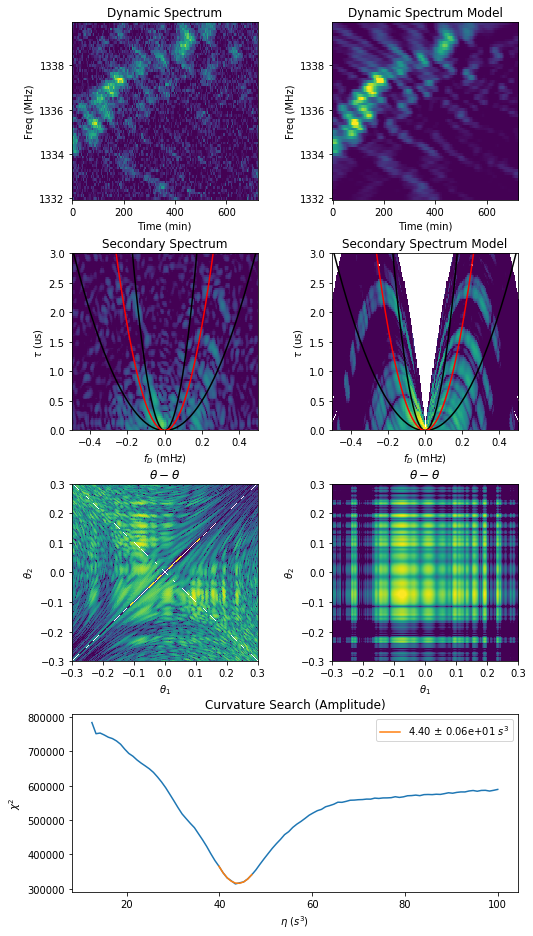

In [6]:

exp_fit=int(('%.0e' %eta_fit.value)[2:])
exp_err=int(('%.0e' %eta_sig.value)[2:])
fmt="{:.%se}" %(exp_fit-exp_err)
fit_string=fmt.format(eta_fit.value)[:2+exp_fit-exp_err]
err_string='0%s' %fmt.format(10**(exp_fit)+eta_sig.value)[1:]

##Best fit sample plots
dspec_ext=ext_find(time.to(u.min),freq2)

##Find dominant eigenvector/value
thth_red,edges_red=THTH.thth_redmap(SS, tau, fd, eta_fit, edges)
w,V=eigsh(thth_red,1)
w=w[0]
V=V[:,0]
##Use dominant eigenvector/value as model
thth2_red=np.outer(V,np.conjugate(V))
thth2_red*=2*np.abs(w)
recov=THTH.rev_map(thth2_red,tau,fd,eta_fit,edges_red)
model=np.fft.ifft2(np.fft.ifftshift(recov))[:dspec2.shape[0],:dspec2.shape[1]].real

##Plotting variables
SS_ext=ext_find(fd,tau)
SS_min=np.median(np.abs(SS)**2)
SS_max=np.max(np.abs(2*recov)**2)*np.exp(-3)

##Compare model to data in plots
grid = plt.GridSpec(4, 2, wspace=0.4, hspace=0.3)
plt.figure(figsize=(8,16))
plt.subplot(grid[0,0])
plt.imshow(dspec2,aspect='auto',origin='lower',extent=dspec_ext,vmin=0,vmax=250)
plt.title('Dynamic Spectrum')
plt.xlabel('Time (min)')
plt.ylabel('Freq (MHz)')
plt.subplot(grid[0,1])
plt.imshow(model,aspect='auto',origin='lower',extent=dspec_ext,vmin=0,vmax=250)
plt.title('Dynamic Spectrum Model')
plt.xlabel('Time (min)')
plt.ylabel('Freq (MHz)')
plt.subplot(grid[1,0])
plt.imshow(np.abs(SS)**2,
           norm=LogNorm(),
           aspect='auto',
           origin='lower',
           extent=SS_ext,
           vmin=SS_min,
           vmax=SS_max)
plt.xlim((-.5,.5))
plt.ylim((0,3))
plt.plot(fd,eta_low*(fd**2),'k')
plt.plot(fd,eta_high*(fd**2),'k')
plt.plot(fd,eta_fit*(fd**2),'r')
plt.title('Secondary Spectrum')
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.subplot(grid[1,1])
plt.imshow(np.abs(2*recov)**2,
           norm=LogNorm(),
           aspect='auto',
           origin='lower',
           extent=SS_ext,
           vmin=SS_min,
           vmax=SS_max)
plt.xlim((-.5,.5))
plt.ylim((0,3))
plt.plot(fd,eta_low*(fd**2),'k')
plt.plot(fd,eta_high*(fd**2),'k')
plt.plot(fd,eta_fit*(fd**2),'r')
plt.title('Secondary Spectrum Model')
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')

thth_min=np.median(np.abs(thth_red))/10
thth_max=np.max(np.abs(thth_red))

plt.subplot(grid[2,0])
plt.imshow(np.abs(thth_red),
           norm=LogNorm(),
           aspect='auto',
           origin='lower',
           extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],
           vmin=thth_min,
           vmax=thth_max)
plt.title(r'$\theta-\theta$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.subplot(grid[2,1])
plt.imshow(np.abs(thth2_red),
           norm=LogNorm(),
           aspect='auto',
           origin='lower',
           extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],
           vmin=thth_min,
           vmax=thth_max)
plt.title(r'$\theta-\theta$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.subplot(grid[3,:])
plt.plot(etas,chisq)
plt.plot(etas_fit,THTH.chi_par(etas_fit.value,*popt),label=r'%s $\pm$ %s $s^3$' %(fit_string,err_string))
plt.xlabel(r'$\eta$ ($s^3$)')
plt.ylabel(r'$\chi^2$')
plt.title('Curvature Search (Amplitude)')
plt.legend()

# Full Curvature Analysis

## Looped Fitting

In [27]:
##Divide dynamic spectrum into small chunks in frequency 
##For some datasets you may need to divide into time chunks aswell 
nchunk=dspec.shape[0]//64

##Arrays for curvatures in each frequency chunk
f0=np.zeros(nchunk)*u.MHz
eta_evo=np.zeros(nchunk)*u.us/u.mHz**2
eta_evo_err=np.zeros(nchunk)*u.us/u.mHz**2

##Loop over chunks
for fc in range(nchunk):
    ##Define dspec and freq array for chunk
    dspec2=dspec[fc*64:(fc+1)*64]
    freq2=freq[fc*64:(fc+1)*64]
    f0[fc]=freq2.mean()
    
    ##Pad before forming dynamic spectrum
    npad=3
    dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

    ##Form SS and coordinate arrays
    SS=np.fft.fftshift(np.fft.fft2(dspec_pad))
    fd=np.fft.fftshift(np.fft.fftfreq((npad+1)*time.shape[0],time[1]-time[0]).to(u.mHz))*u.mHz
    tau=np.fft.fftshift(np.fft.fftfreq((npad+1)*freq2.shape[0],freq[1]-freq[0]).to(u.us))*u.us

    ##Define range of curvatures to search
    eta_low=.5*u.us/(.04*u.mHz**2)
    eta_high=4*u.us/(.04*u.mHz**2)


    ##Estimate noise in dynamic spectrum
    temp=np.fft.fftshift(np.abs(np.fft.fft2(dspec)/np.sqrt(dspec.shape[0]*dspec.shape[1]))**2)
    N=np.sqrt(temp[:temp.shape[0]//6,:temp.shape[1]//6].mean())

    ##Setup for chisq search
    etas=np.linspace(eta_low.value,eta_high.value,100)*eta_low.unit
    chisq=np.zeros(etas.shape[0])
    ##Bin Edges for thth plot 
    ##(should be symmetric about 0 and contain an even number of points)
    edges=np.linspace(-.4,.4,512)
    ##Determine chisq for each curvature
    for i in range(etas.shape[0]):
        eta=etas[i]
        ##Create thth plot
        ##The redmap fuction automatically crops the array to stay within the SS
        thth_red,edges_red=THTH.thth_redmap(SS, tau, fd, eta, edges)
        ##Find first eigenvector and value
        w,V=eigsh(thth_red,1)
        w=w[0]
        V=V[:,0]
        ##Use larges eigenvector/value as model
        thth2_red=np.outer(V,np.conjugate(V))
        thth2_red*=np.abs(w)
        ##Map back to SS for high
        recov=THTH.rev_map(thth2_red,tau,fd,eta,edges_red)
        model=2*np.fft.ifft2(np.fft.ifftshift(recov))[:dspec2.shape[0],:dspec2.shape[1]].real
        chisq[i]=(((dspec2-model)**2)/N).sum()

    e_min=etas[chisq==chisq.min()][0]
    etas_fit=etas[np.abs(etas-e_min)<.1*e_min]
    chisq_fit=chisq[np.abs(etas-e_min)<.1*e_min]
    C=chisq_fit.min()
    x0=etas_fit[chisq_fit==C][0].value
    A=(chisq_fit[0]-C)/((etas_fit[0].value-x0)**2)
    popt,pcov=curve_fit(THTH.chi_par,etas_fit.value,chisq_fit,p0=np.array([A,x0,C]))
    eta_fit=popt[1]*etas.unit
    eta_sig=np.sqrt((chisq_fit-THTH.chi_par(etas_fit.value,*popt)).std()/popt[0])*etas.unit

    eta_evo[fc]=eta_fit
    eta_evo_err[fc]=eta_sig


## Curvature Evolution

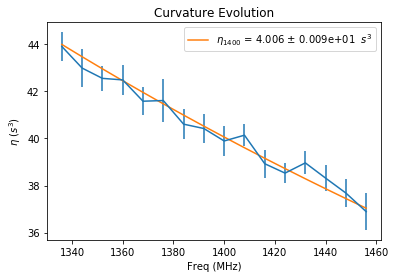

In [28]:
##Fit for overall curvature evolution
popt,pcov=curve_fit(eta_func,f0.value,eta_evo.value,sigma=eta_evo_err.value,p0=[np.median(eta_evo.value*f0.value)])
A=popt[0]*(u.us)*u.MHz**2/u.mHz**2
A_err=np.sqrt(pcov[0,0])*u.us*u.MHz**2/u.mHz**2
A/=(1400*u.MHz)**2
A_err/=(1400*u.MHz)**2

exp_fit=int(('%.0e' %A.value)[2:])
exp_err=int(('%.0e' %A_err.value)[2:])
fmt="{:.%se}" %(exp_fit-exp_err)
fit_string=fmt.format(A.value)[:2+exp_fit-exp_err]
err_string='0%s' %fmt.format(10**(exp_fit)+A_err.value)[1:]

plt.figure()
plt.errorbar(f0.value,eta_evo.value,yerr=eta_evo_err.value)
plt.plot(f0.value,eta_func(f0.value,*popt),label=r'$\eta_{1400}$ = %s $\pm$ %s  $s^3$' %(fit_string, err_string))
plt.title(r'Curvature Evolution')
plt.xlabel('Freq (MHz)')
plt.ylabel(r'$\eta$ ($s^3$)')
plt.legend()

# Phase Retrieval

## Retieve for overlapping chunks

In [30]:
##Perform phase retreival on chunks of data

nchunk=(dspec.shape[0]-32)//32

chunks=np.zeros((nchunk,64,dspec.shape[1]),dtype=complex)

for fc in range(nchunk):
    dspec2=dspec[fc*32:fc*32+64]
    freq2=freq[fc*32:fc*32+64]
    eta=A*((1400*u.MHz/freq2.mean())**2)
    


    npad=3

    dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

    SS=np.fft.fftshift(np.fft.fft2(dspec_pad))
    fd=np.fft.fftshift(np.fft.fftfreq((npad+1)*time.shape[0],time[1]-time[0]).to(u.mHz))*u.mHz
    tau=np.fft.fftshift(np.fft.fftfreq((npad+1)*freq2.shape[0],freq[1]-freq[0]).to(u.us))*u.us

   
    thth_red,edges_red=THTH.thth_redmap(SS, tau, fd, eta, edges)
    w,V=eigsh(thth_red,1)
    w=w[0]
    V=V[:,0]
    
    thth2_red=thth_red*0
    thth2_red[thth2_red.shape[0]//2,:]=np.conjugate(V)*np.sqrt(w)
    recov=THTH.rev_map(thth2_red,tau,fd,eta,edges_red)
    model_E=np.fft.ifft2(np.fft.ifftshift(recov))[:dspec2.shape[0],:dspec2.shape[1]]
    model_E*=(dspec2.shape[0]*dspec2.shape[1]/2)
    model_E=model_E[:dspec2.shape[0],:dspec2.shape[1]]
    chunks[fc,:,:]=model_E

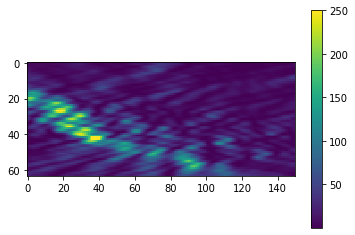

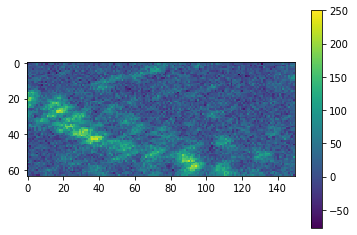

In [31]:
plt.figure()
plt.imshow(np.abs(chunks[0,:,:])**2,vmax=250)
plt.colorbar()
plt.figure()
plt.imshow(dspec[:chunks.shape[1],:chunks.shape[2]],vmax=250)
plt.colorbar()

## Rotate and combine chunks

1.5968187118046633

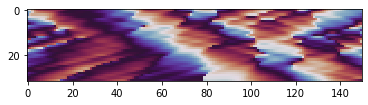

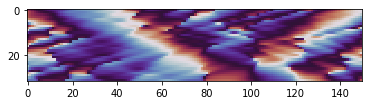

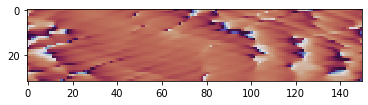

In [39]:
plt.figure()
plt.imshow(np.angle(chunks[0,32:,:]),cmap='twilight')
plt.figure()
plt.imshow(np.angle(chunks[1,:32,:]),cmap='twilight')
plt.figure()
plt.imshow(np.angle(chunks[0,32:,:]*np.conjugate(chunks[1,:32,:])),vmin=-np.pi,vmax=np.pi,cmap='twilight')
np.angle(chunks[0,32:,:]*np.conjugate(chunks[1,:32,:])).mean()

Text(0.5, 1.0, 'Wave Field Phase')

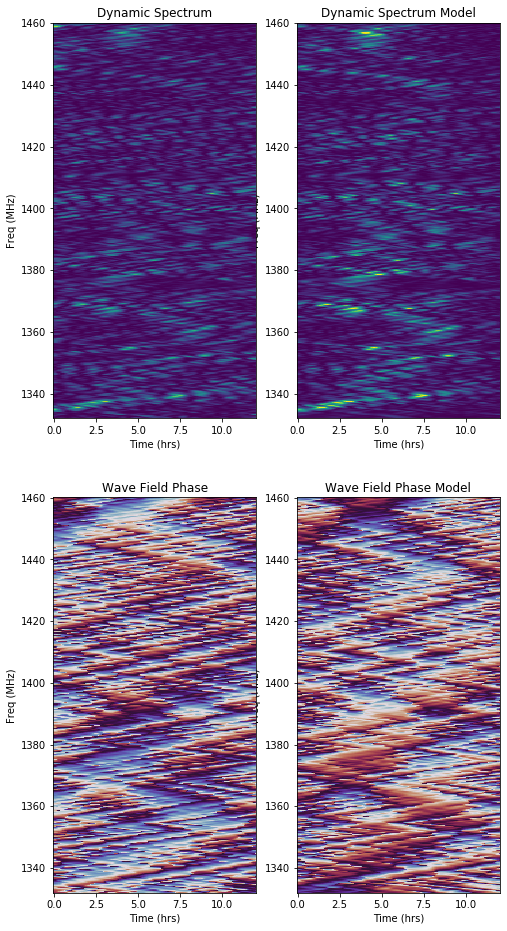

In [40]:
E_recov=np.zeros(espec.shape,dtype=complex)
for i in range(nchunk):
    msk=np.ones(64)
    if i>0:
        msk[:32]=np.sin((np.pi/2)*np.linspace(0,31,32)/32)**2
    if i<nchunk-1:
        msk[32:]=np.cos((np.pi/2)*np.linspace(0,31,32)/32)**2
    if i>0:
        rot=np.angle((E_recov[(i-1)*32:(i-1)*32+64,:][32:,:]*np.conjugate(chunks[i,:,:][:32,:])).mean())
    else:
        rot=0
    E_recov[i*32:i*32+64,:]+=chunks[i,:,:]*msk[:,np.newaxis]*np.exp(1j*rot)

    
dspec_ext=ext_find(time.to(u.hour),freq)
plt.figure(figsize=(8,16))
plt.subplot(222)
plt.imshow(np.abs(E_recov)**2,aspect='auto',origin='lower',vmin=0,vmax=250,extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Dynamic Spectrum Model')
plt.subplot(221)
plt.imshow(np.abs(espec)**2,aspect='auto',origin='lower',vmin=0,vmax=250,extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Dynamic Spectrum')
plt.subplot(224)
plt.imshow(np.angle(E_recov),cmap='twilight',aspect='auto',origin='lower',extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Wave Field Phase Model')
plt.subplot(223)
plt.imshow(np.angle(espec),cmap='twilight',aspect='auto',origin='lower',extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Wave Field Phase')

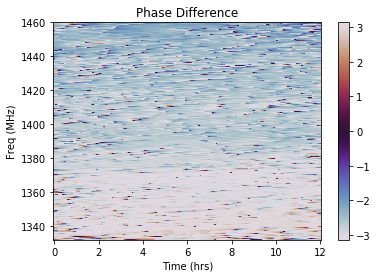

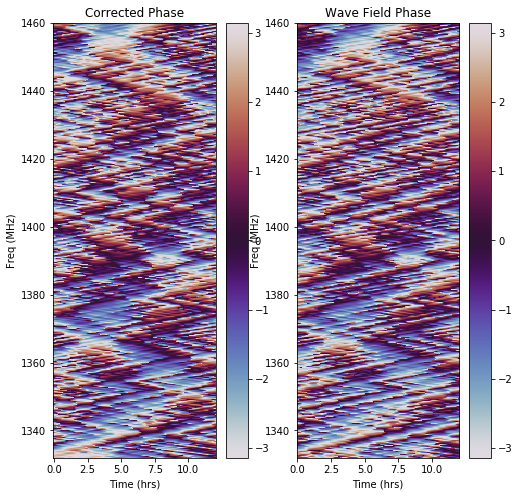

In [42]:
plt.figure()
plt.imshow(np.angle(espec*np.conjugate(E_recov)),
           cmap='twilight',
           aspect='auto',
           origin='lower',
           extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Phase Difference')
plt.colorbar()
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(np.angle(E_recov*np.exp(1j*np.angle((espec*np.conjugate(E_recov)).mean()))),cmap='twilight',aspect='auto',origin='lower',extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Corrected Phase')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(espec),cmap='twilight',aspect='auto',origin='lower',extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Wave Field Phase')
plt.colorbar()

/home/daniel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


(-1, 3)

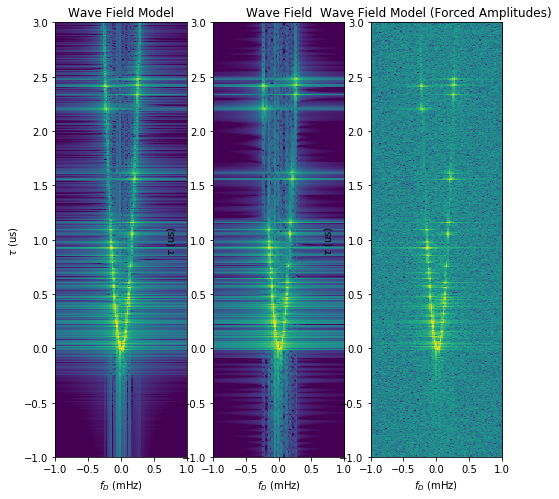

In [43]:
fd_full=np.fft.fftshift(np.fft.fftfreq(time.shape[0],time[1]-time[0]).to(u.mHz))*u.mHz
tau_full=np.fft.fftshift(np.fft.fftfreq(freq.shape[0],freq[1]-freq[0]).to(u.us))*u.us
SS_ext_full=ext_find(fd,tau)
temp2=np.nan_to_num(np.sqrt(dspec))*np.exp(1j*np.angle(E_recov))

plt.figure(figsize=(8,8))
plt.subplot(131)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(E_recov)))**2,
           norm=LogNorm(),
           origin='lower',
           aspect='auto',
           extent=SS_ext_full,
           vmax=1e10,
           vmin=1e2)
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Wave Field Model')
plt.xlim((-1,1))
plt.ylim((-1,3))
plt.subplot(132)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(espec)))**2,
           norm=LogNorm(),
           origin='lower',
           aspect='auto',
           extent=SS_ext_full,
           vmax=1e10,
           vmin=1e2)
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Wave Field')
plt.xlim((-1,1))
plt.ylim((-1,3))

plt.subplot(133)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(temp2)))**2,
           norm=LogNorm(),
           origin='lower',
           aspect='auto',
           extent=SS_ext_full,
           vmax=1e10,
           vmin=1e2)
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Wave Field Model (Forced Amplitudes)')
plt.xlim((-1,1))
plt.ylim((-1,3))